In [26]:
from PIL import Image
from IPython.display import display

import PyNvCodec as nvc
import numpy as np
import time
import os

In [27]:
def make_img(buffer,w,h,format,merge=False):
    """
    utility function to build image from buffers. requires numpy, pillow. 
    
    Parameters
    ----------
    buffer:  Numpy array
    w, h :   Width and height of image, regardeless of buffer format
    format : Format of buffer. may be RGB, RGB_Planar, NV12, YUV420p
    merge :  Whether we should reconstitute rgb image or display the whole buffer (as grayscale image)
    """
    
    match format:
        case 'RGB':
            return Image.fromarray(buffer.reshape(h,w,3))
        case 'RGB_Planar':
            if not merge:
                return Image.fromarray(buffer.reshape(h*3,w))
            else:
                return Image.fromarray(buffer.reshape(3,h,w).transpose(2,1,0)).transpose(Image.TRANSPOSE)
        case 'NV12':
            if not merge:
                return Image.fromarray(buffer.reshape(h*3//2,w))
            else:
                y=Image.fromarray(buffer[:w*h].reshape(h,w))
                u=Image.fromarray(buffer[w*h:][::2].reshape(h//2,w//2).repeat(2, axis=0).repeat(2, axis=1))
                v=Image.fromarray(buffer[w*h+1:][::2].reshape(h//2,w//2).repeat(2, axis=0).repeat(2, axis=1))
                return Image.merge('YCbCr', (y,u,v))
        case 'YUV420p':
            if not merge:
                return Image.fromarray(buffer.reshape(h*3//2,w))
            else:
                y=Image.fromarray(buffer[:w*h].reshape(h,w))
                u=Image.fromarray(buffer[w*h:w*h*5//4].reshape(h//2,w//2).repeat(2, axis=0).repeat(2, axis=1))
                v=Image.fromarray(buffer[w*h*5//4:].reshape(h//2,w//2).repeat(2, axis=0).repeat(2, axis=1))
                return Image.merge('YCbCr', (y,u,v))

In [28]:
class TwoPassConverter:
    def __init__(self,fmt,w,h):
        self.fmt,self.w,self.h=fmt,w,h
        self.to_yuv=nvc.PySurfaceConverter(fmt,nvc.PixelFormat.YUV420,gpu_id=0)
        self.to_rgb=nvc.PySurfaceConverter(nvc.PixelFormat.YUV420,nvc.PixelFormat.RGB,gpu_id=0)
        self.surf_yuv = nvc.Surface.Make(format=self.fmt, width=self.w,height=self.h,gpu_id=0)

    def Run(self,src,dst,cc_ctx):
        self.surf_yuv = nvc.Surface.Make(format=self.fmt, width=self.w,height=self.h,gpu_id=0)
        success,details=self.to_yuv.Run(src,self.surf_yuv,cc_ctx)
        if not success:
            return success, details
        success,details=self.to_rgb.Run(self.surf_yuv,dst,cc_ctx)
        return success, details

class OnePassConverter:
    def __init__(self,fmt,w,h):
        self.fmt, self.w, self.h=fmt, w, h
        self.to_rgb=nvc.PySurfaceConverter(fmt,nvc.PixelFormat.RGB,gpu_id=0)
        
    def Run(self,src,dst,cc_ctx):
        success,details=self.to_rgb.Run(src,dst,cc_ctx)
        return success, details

def check(success, info):
    if not success:
        print(sys._getframe(1).f_lineno)
        print(info)

In [29]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

In [30]:
url="/home/yves/Devel/python/vali_luma_chroma_shift/hires.mp4"
#url=f"{os.environ['VALI']}/tests/data/test.mp4"
#url=f"/home/yves/nvidia/VALI/tests/data/test.mp4"

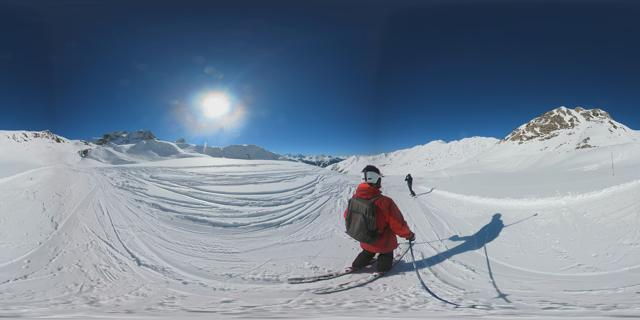

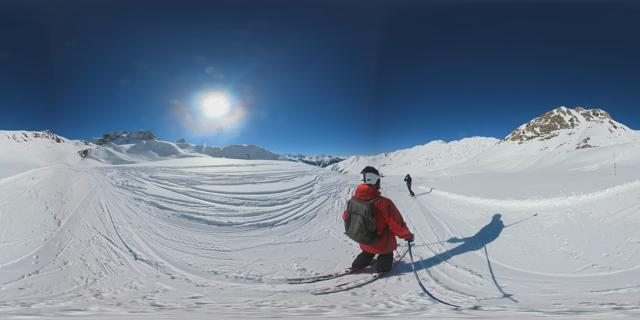

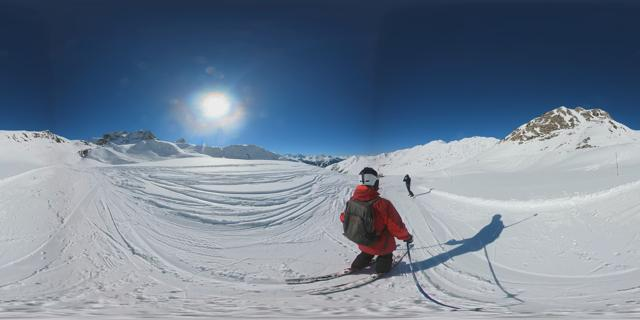

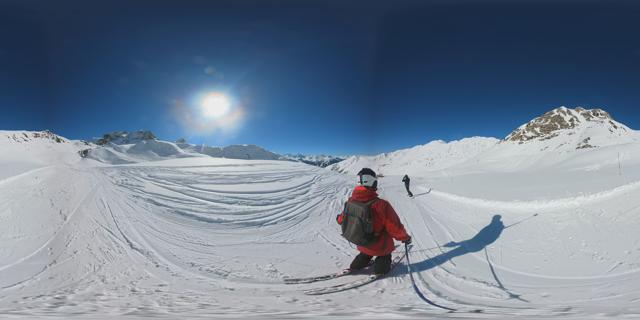

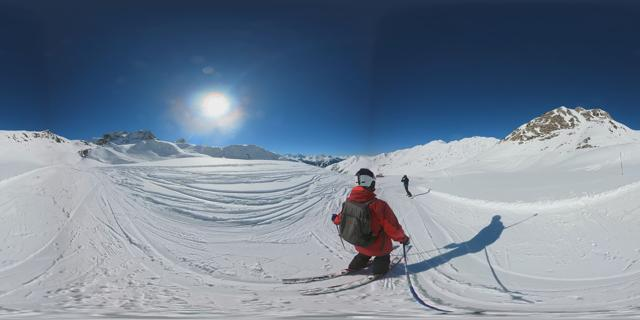

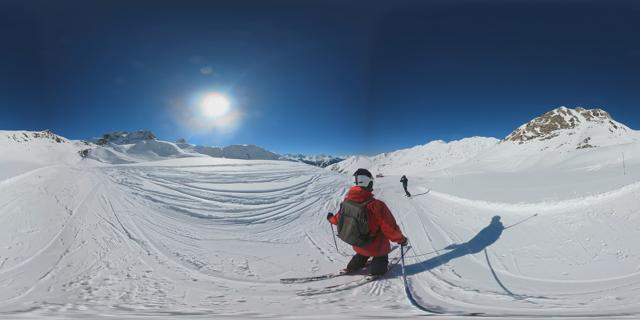

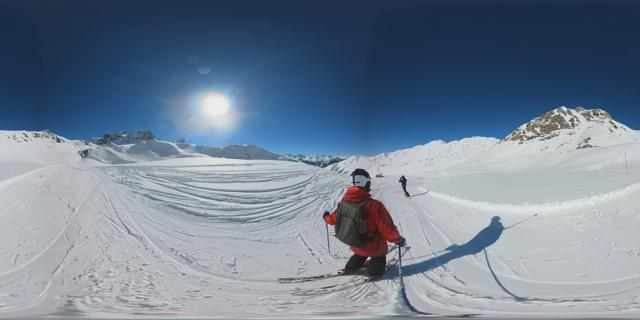

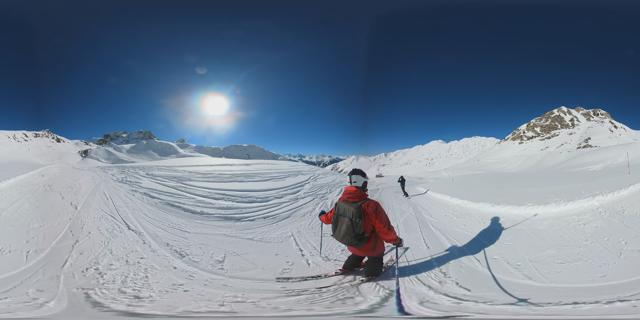

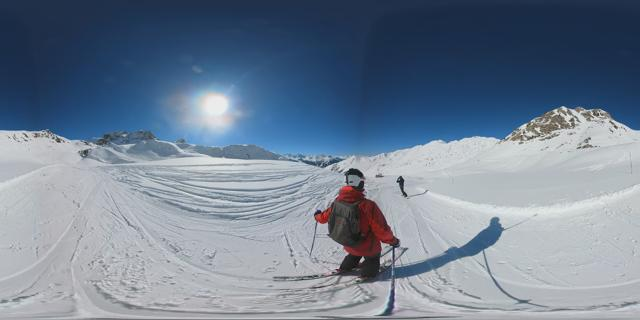

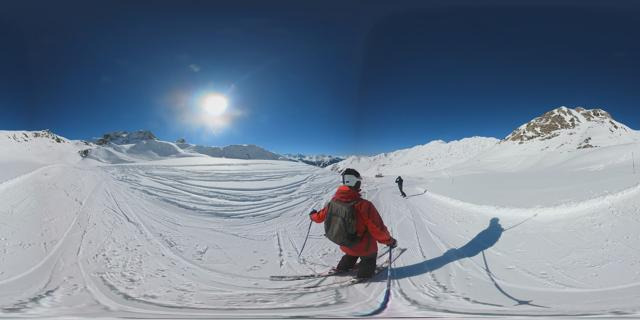

In [31]:
# GPU-accelerated decoder
pyDec = nvc.PyDecoder( url, {}, gpu_id=0)
assert (pyDec.Format()==nvc.PixelFormat.NV12)
pyCvt=OnePassConverter(pyDec.Format(),pyDec.Width(),pyDec.Height())
pyDwn = nvc.PySurfaceDownloader(gpu_id=0)

# Raw decoded Surface
surf_src = nvc.Surface.Make(format=pyDec.Format(),       width=pyDec.Width(), height=pyDec.Height(), gpu_id=0)
surf_dst = nvc.Surface.Make(format=nvc.PixelFormat.RGB,  width=pyDec.Width(), height=pyDec.Height(), gpu_id=0)

# Numpy array which contains decoded RGB Surface
rgb_frame = np.ndarray(dtype=np.uint8,shape=surf_dst.HostSize())
nv_frame  = np.ndarray(dtype=np.uint8,shape=pyDec.Width()*pyDec.Height()*3//2)

for _ in range (10):
    assert (pyDec.Format()==nvc.PixelFormat.NV12)

    # Decode single Surface
    success, info = pyDec.DecodeSingleSurface(surf_src)
    check(success,info)
    #time.sleep(0.1)
    if 1:
        ## download nv12 plane, convert with PIL and save
        success = pyDwn.Run(surf_src, nv_frame)
        check(success,info)
        img_pil=make_img(nv_frame,pyDec.Width(),pyDec.Height(),'NV12',merge=True)
    if 1:
        import pycuda
        import pycuda.autoinit
        ## same, but download using pycuda (requires GpuMem())! works correcttly!
        device_to_host=pycuda.driver.Memcpy2D()
        device_to_host.set_src_device(surf_src.PlanePtr(0).GpuMem())
        device_to_host.set_dst_host(nv_frame)
        device_to_host.width_in_bytes = surf_src.PlanePtr(0).Width()
        device_to_host.src_pitch = surf_src.PlanePtr(0).Pitch()
        device_to_host.dst_pitch = surf_src.PlanePtr(0).Width()
        device_to_host.src_height = surf_src.PlanePtr(0).Height()
        device_to_host.height = surf_src.PlanePtr(0).Height()
        device_to_host(aligned=True)
        img_cuda=make_img(nv_frame,pyDec.Width(),pyDec.Height(),'NV12',merge=True)

    if 1:
        ## convert to rgb, download and display
        success, info=pyCvt.Run(surf_src,surf_dst,None)
        check(success,info)
        success = pyDwn.Run(surf_dst, rgb_frame)
        check(success,info)
        img_vali=make_img(rgb_frame,pyDec.Width(),pyDec.Height(),'RGB',merge=True)

    display(img_pil.resize((640,640*pyDec.Height()//pyDec.Width())))